# Model Inversion & Stealing

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
device = 'cuda:0'

In [5]:
import numpy as np
import torch
from torchvision import transforms, datasets
from torchvision.utils import save_image

import unsplit.attacks as unsplit
from unsplit.models import *
from unsplit.util import *

from tqdm import tqdm

Change the dataset and split layer values as desired. Dataset can be one of `mnist`, `f_mnist`, while the split depth is between 1 and 6 both for CNN and MLP.

In [6]:
dataset_name = "mnist"
architecture = "mlp"
device = "cuda:0"
batch_size = 64

n_epochs = 10
split_layer = 1

In [7]:
def create_models_and_data(dataset_name="mnist", architecture="mlp", batch_size=64, device="cuda:0", seed=0):
    assert dataset_name in ["mnist", "f_mnist"], "Wrong dataset name. Valid options are 'mnist' and 'f_mnist'."
    assert architecture in ["mlp", "cnn"], "Wrong architecture name. Valid options are 'mlp' and 'cnn'."
    dataset_creator = datasets.MNIST if dataset_name == "mnist" else datasets.FashionMNIST
    model_creator = MLP if architecture == "mlp" else CNN
    
    trainset = dataset_creator(f'data/{dataset_name}', download=True, train=True, transform=transforms.ToTensor())
    testset = dataset_creator(f'data/{dataset_name}', download=True, train=False, transform=transforms.ToTensor())
    
    torch.manual_seed(seed)
    client, server = model_creator().to(device), model_creator().to(device)
    return client, server, trainset, testset

In [8]:
client, server, trainset, testset = create_models_and_data(dataset_name=dataset_name, 
                                                           architecture=architecture, 
                                                           batch_size=batch_size,
                                                           device=device)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:01<00:00, 7420436.48it/s]


Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 216272.80it/s]


Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 2005968.52it/s]


Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 1861312.04it/s]


Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



The next part trains the client and server models. You can skip this step and launch the attack directly as well.

In [9]:
def train_client_server(client, server, trainset, testset, split_layer, n_epochs=10, device="cuda:0", batch_size=64):
    trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
    testloader = torch.utils.data.DataLoader(testset, shuffle=True, batch_size=64)
    
    client_opt = torch.optim.Adam(client.parameters(), lr=0.001, amsgrad=True)
    server_opt = torch.optim.Adam(server.parameters(), lr=0.001, amsgrad=True)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(n_epochs):
        running_loss = 0
        for images, labels in tqdm(trainloader):
            images, labels = images.to(device), labels.to(device)
            client_opt.zero_grad()
            server_opt.zero_grad()

            client_pred = client(images, end=split_layer)
            pred = server(client_pred, start=split_layer+1)

            loss = criterion(pred, labels)
            loss.backward()
            running_loss += loss

            server_opt.step()
            client_opt.step()
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_acc(client, server, testloader, split=split_layer)}')
    return client, server

In [10]:
client, server = train_client_server(client=client, server=server, trainset=trainset, testset=testset, 
                                     split_layer=split_layer, n_epochs=10, device=device)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:14<00:00, 66.42it/s]


Epoch: 0 Loss: 0.21331937611103058 Acc: 0.9663999676704407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 67.84it/s]


Epoch: 1 Loss: 0.09071116149425507 Acc: 0.97079998254776


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 67.94it/s]


Epoch: 2 Loss: 0.06066155806183815 Acc: 0.97489994764328


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 72.07it/s]


Epoch: 3 Loss: 0.04743756353855133 Acc: 0.9811999797821045


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 95.60it/s]


Epoch: 4 Loss: 0.032594770193099976 Acc: 0.979699969291687


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:14<00:00, 66.95it/s]


Epoch: 5 Loss: 0.02699957601726055 Acc: 0.9819999933242798


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:13<00:00, 71.78it/s]


Epoch: 6 Loss: 0.020119933411478996 Acc: 0.9819999933242798


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 73.57it/s]


Epoch: 7 Loss: 0.01892716810107231 Acc: 0.9781000018119812


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 118.28it/s]


Epoch: 8 Loss: 0.016076814383268356 Acc: 0.9803999662399292


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:07<00:00, 121.85it/s]


Epoch: 9 Loss: 0.01084762904793024 Acc: 0.9811999797821045


We are now ready to launch the attack. The next code cell loads `COUNT` many examples from each class of the dataset. Those examples will be used as targets in the attack.

In [11]:
COUNT = 1
inversion_targets = [get_examples_by_class(testset, i, count=COUNT).to(device) for i in range(10)]

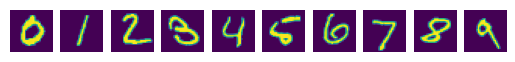

In [12]:
display_imagelist(inversion_targets)

We now launch the attack, iterating over the examples from the previous cell.

You can change the `main_iters`, `input_iters`, and `model_iters` variables to observe how the attack performs under different configurations. 

In [13]:
main_iters, input_iters, model_iters = 200, 20, 20
lambda_l2, lambda_tv = 0.1, 1.0

In [14]:
def launch_attack(inversion_targets, client, split_layer, clone_architecture="mlp",
                  main_iters=1000, input_iters=100, model_iters=100,
                  lambda_tv=0.1, lambda_l2=1, device="cuda:0"):
    assert clone_architecture in ["mlp", "cnn"], "Wrong architecture name. Valid options are 'mlp' and 'cnn'."
    clone = MLP() if architecture == "mlp" else CNN()
    mse = torch.nn.MSELoss()
    
    reconstructed_images, reconstruction_losses = [], []
    cut_layer_training_losses = []
    for idx, target in enumerate(inversion_targets):
        # obtain client output
        with torch.no_grad():
            client_out = client(target, end=split_layer)

        # perform the attack
        target_size = target.size()
        reconstructed, cur_loss_arr = unsplit.model_inversion_stealing(
            clone, split_layer, client_out, target_size,
            main_iters=main_iters, input_iters=input_iters, model_iters=model_iters, 
            lambda_tv=lambda_tv, lambda_l2=lambda_l2, device=device
        )
        cut_layer_training_losses.append(cur_loss_arr)

        # save result
        reconstructed = normalize(reconstructed)
        reconstructed_images.append(reconstructed)
        reconstruction_loss = mse(reconstructed, target)
        reconstruction_losses.append(reconstruction_loss.item())
    return clone, reconstructed_images, reconstruction_losses, cut_layer_training_losses

In [15]:
clone, reconstructed_images, reconstruction_losses, cut_layer_training_losses = launch_attack(
    inversion_targets, client, split_layer, clone_architecture=architecture,
    main_iters=main_iters, input_iters=input_iters, model_iters=model_iters,
    lambda_tv=lambda_tv, lambda_l2=lambda_l2, device=device
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:13<00:00, 15.16it/s]


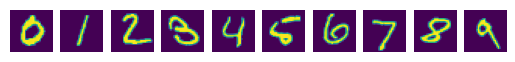

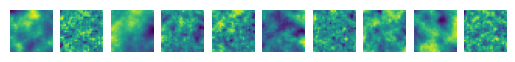

In [16]:
display_imagelist(inversion_targets)
display_imagelist(reconstructed_images)

In [17]:
def compute_metrics(inversion_targets, reconstructed_images, 
                    reconstruction_losses, cut_layer_training_losses,
                    compute_fid=False):
    reconstruction_mse = np.mean(reconstruction_losses)
    cut_layer_mse = np.mean([loss_arr[-1] for loss_arr in cut_layer_training_losses])
    print(f"Recounstruction MSE: {reconstruction_mse:.3f}")
    print(f"Log10 of cut layer MSE: {np.log10(cut_layer_mse):.3f}")
    if compute_fid:
        print(f"FID: {compute_fid(inversion_targets, reconstructed_images):.1f}")

In [18]:
compute_metrics(inversion_targets, reconstructed_images, reconstruction_losses, cut_layer_training_losses)

Recounstruction MSE: 0.272
Log10 of cut layer MSE: -6.149
